In [128]:
import os
print("Current working directory:", os.getcwd())


Current working directory: c:\4TH YEAR\TERM 1\THS-ST2\Configuration


# Imports and Helper Functions

In [129]:

import os
import json
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

def load_raster(path):
    ds = rasterio.open(path)
    arr = ds.read(1).astype('float32')
    arr[arr == ds.nodata] = np.nan
    return arr, ds.profile

def save_raster(arr, profile, out_path, nodata_value=-9999):
    profile2 = profile.copy()
    profile2.update(dtype=rasterio.float32, count=1, compress='lzw', nodata=nodata_value)
    arr2 = np.where(np.isnan(arr), nodata_value, arr).astype(rasterio.float32)
    with rasterio.open(out_path, 'w', **profile2) as dst:
        dst.write(arr2, 1)
    print('Saved', out_path)

def normalize(arr, method='minmax'):
    # arr may contain nan
    a = np.array(arr, dtype='float32')
    m = np.nanmin(a)
    M = np.nanmax(a)
    if np.isnan(m) or np.isnan(M) or M == m:
        return np.full_like(a, np.nan)
    return (a - m) / (M - m)


# Configuration Setup

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling

# Base directory
base_dir = r'C:\4TH YEAR\TERM 1\THS-ST2\Configuration'

# Subfolders 
folders = ['building_footprint', 'dem', 'drainage', 'flood_maps']

# Helper functions 
def find_raster_in_folder(folder_path):
    """Find the first raster file (.tif, .tiff, .img) in a folder."""
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return None
    for f in os.listdir(folder_path):
        if f.lower().endswith(('.tif', '.tiff', '.img')):
            return os.path.join(folder_path, f)
    print(f"No raster found in: {folder_path}")
    return None


def load_raster(fp):
    """Load raster as array and profile."""
    with rasterio.open(fp) as src:
        return src.read(1).astype('float32'), src.profile


def normalize(arr):
    """Normalize raster array to 0–1 scale."""
    arr_min, arr_max = np.nanmin(arr), np.nanmax(arr)
    if arr_max - arr_min == 0:
        return np.zeros_like(arr)
    return (arr - arr_min) / (arr_max - arr_min)


def match_raster(ref_arr, ref_profile, arr, arr_profile):
    """Resample raster to match reference raster's CRS, resolution, and extent."""
    dst = np.empty_like(ref_arr, dtype='float32')
    reproject(
        source=arr,
        destination=dst,
        src_transform=arr_profile['transform'],
        src_crs=arr_profile['crs'],
        dst_transform=ref_profile['transform'],
        dst_crs=ref_profile['crs'],
        resampling=Resampling.bilinear
    )
    return dst


def save_raster(array, profile, output_path):
    """Save raster as GeoTIFF file."""
    profile.update(dtype=rasterio.float32, count=1)
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(array.astype(rasterio.float32), 1)

# --- Find all raster files ---
paths = {}
for f in folders:
    folder_path = os.path.join(base_dir, f)
    raster_fp = find_raster_in_folder(folder_path)
    if raster_fp:
        paths[f] = raster_fp
        print(f"Found raster for {f}: {raster_fp}")
    else:
        print(f"Skipping {f} (no file found).")

if not paths:
    raise FileNotFoundError("No raster files found. Check your folder paths.")
else:
    print("\nConfiguration successful! All rasters found and ready.")


✅ Found raster for building_footprint: C:\4TH YEAR\TERM 1\THS-ST2\Configuration\building_footprint\building_footprint.tif
✅ Found raster for dem: C:\4TH YEAR\TERM 1\THS-ST2\Configuration\dem\manila_clipped_DEM.tif
✅ Found raster for drainage: C:\4TH YEAR\TERM 1\THS-ST2\Configuration\drainage\manila_streams.tif
✅ Found raster for flood_maps: C:\4TH YEAR\TERM 1\THS-ST2\Configuration\flood_maps\AL_M_Chicago_10.tif

✅ Configuration successful! All rasters found and ready.


# Susceptibiltiy 

In [ ]:
def weighted_overlay(paths, weights):
    """Compute weighted overlay given raster paths and weight values."""
    arrays, profiles = {}, {}
    for k, p in paths.items():
        arr, prof = load_raster(p)
        arrays[k] = arr
        profiles[k] = prof

    ref_key = next(iter(arrays))
    ref_arr, ref_prof = arrays[ref_key], profiles[ref_key]
    score = np.zeros_like(ref_arr, dtype='float32')

    for k, w in weights.items():
        if k not in arrays:
            print(f"⚠️ Missing layer: {k}")
            continue
        arr, prof = arrays[k], profiles[k]
        arr_resampled = match_raster(ref_arr, ref_prof, arr, prof)
        arr_n = normalize(arr_resampled)
        # Invert values for layers where high = less risk
        if k in ('dem', 'drainage'):
            arr_n = 1 - arr_n
        score += np.nan_to_num(arr_n) * w

    return score, ref_prof


# Susceptibility weights 
sus_weights = {
    'dem': 0.4,
    'drainage': 0.3,
    'flood_maps': 0.2,
    'building_footprint': 0.1
}

# Compute susceptibility 
sus_map, sus_prof = weighted_overlay(paths, sus_weights)
save_raster(sus_map, sus_prof, os.path.join(base_dir, 'susceptibility_map.tif'))
print("Susceptibility map created and saved successfully!")


✅ Susceptibility map created and saved successfully!


# Resiliency 

In [ ]:
# Resiliency weights 
res_weights = {
    'building_footprint': 0.4,
    'drainage': 0.2,
    'flood_maps': 0.2,
    'dem': 0.2
}

# Compute resiliency 
res_map, res_prof = weighted_overlay(paths, res_weights)
save_raster(res_map, res_prof, os.path.join(base_dir, 'resiliency_map.tif'))
print("✅ Resiliency map created and saved successfully!")


✅ Resiliency map created and saved successfully!


# Visualization

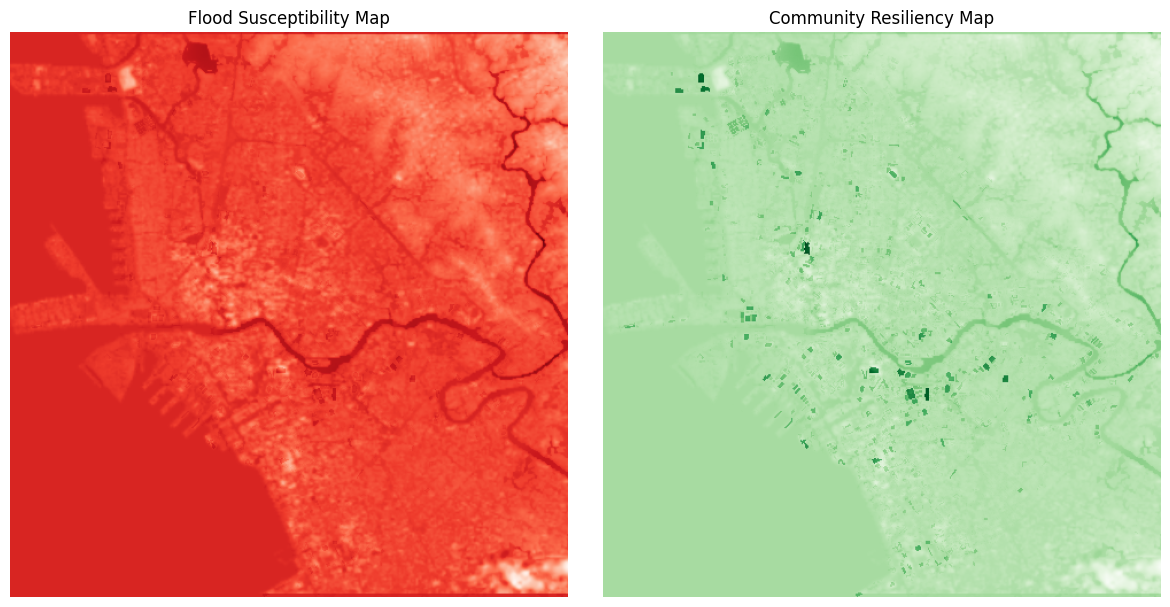

In [133]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(sus_map, cmap='Reds')
axes[0].set_title("Flood Susceptibility Map")

axes[1].imshow(res_map, cmap='Greens')
axes[1].set_title("Community Resiliency Map")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()


# Visualization with Legend

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# Define output directory for visual maps 
output_dir = os.path.join(base_dir, "Visual_Maps")
os.makedirs(output_dir, exist_ok=True)

# Define color maps 
sus_cmap = plt.cm.Reds       # red = more susceptible
res_cmap = plt.cm.Greens     # green = more resilient

# Helper function to plot with colorbar and save 
def plot_with_colorbar(array, title, cmap, filename, vmin=0, vmax=1):
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(array, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')

    # Add colorbar legend
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Score (0 = Low, 1 = High)', fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    # Save figure
    save_path = os.path.join(output_dir, filename)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"✅ Saved: {save_path}")


# Plot and export susceptibility map 
plot_with_colorbar(
    sus_map,
    "Flood Susceptibility Map",
    sus_cmap,
    "susceptibility_map_visual.png"
)

# Plot and export resiliency map 
plot_with_colorbar(
    res_map,
    "Community Resiliency Map",
    res_cmap,
    "resiliency_map_visual.png"
)

print("\nAll visual maps exported successfully! Check your 'Visual_Maps' folder.")


✅ Saved: C:\4TH YEAR\TERM 1\THS-ST2\Configuration\Visual_Maps\susceptibility_map_visual.png
✅ Saved: C:\4TH YEAR\TERM 1\THS-ST2\Configuration\Visual_Maps\resiliency_map_visual.png

✅ All visual maps exported successfully! Check your 'Visual_Maps' folder.


# Combined

c:\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128997 (\N{LARGE RED SQUARE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129001 (\N{LARGE GREEN SQUARE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129000 (\N{LARGE YELLOW SQUARE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11035 (\N{BLACK LARGE SQUARE}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


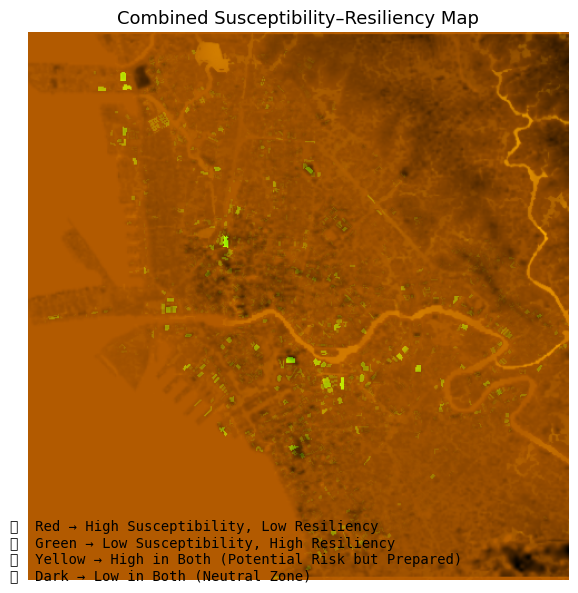

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure both maps are normalized (0–1 range)
sus_norm = (sus_map - np.nanmin(sus_map)) / (np.nanmax(sus_map) - np.nanmin(sus_map))
res_norm = (res_map - np.nanmin(res_map)) / (np.nanmax(res_map) - np.nanmin(res_map))

# Composite Map: Susceptibility vs Resiliency 
# Red = High susceptibility, Green = High resiliency
# Yellow/orange = both high (conflict zones)
combined_rgb = np.zeros((sus_norm.shape[0], sus_norm.shape[1], 3), dtype='float32')
combined_rgb[..., 0] = sus_norm              # Red channel = Susceptibility
combined_rgb[..., 1] = res_norm              # Green channel = Resiliency
combined_rgb[..., 2] = 0                     # Blue left as 0 for clarity

# Display
plt.figure(figsize=(6, 6))
plt.imshow(combined_rgb)
plt.title("Combined Susceptibility–Resiliency Map", fontsize=13)
plt.axis('off')

# --- Add Explanation Legend ---
legend_patches = [
    ("Red", "High Susceptibility, Low Resiliency"),
    ("Green", "Low Susceptibility, High Resiliency"),
    ("Yellow", "High in Both (Potential Risk but Prepared)"),
    ("Dark", "Low in Both (Neutral Zone)")
]

plt.figtext(0.02, 0.02, "\n".join([f"{c} → {t}" for c, t in legend_patches]),
            fontsize=10, ha="left", va="bottom", family="monospace")

plt.tight_layout()
plt.show()
